In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import pymc as pm

# Unit 4 Exercises: Tinkering Hierarchical Models

These exercises are designed to force you to look at the nuances of the models we looked at in class, while exploring some "what ifs". There's also some mild data wrangling for you to enjoy at in task6.



**Task1**:

Redo the chemical shift hierarchical model, execpt with all Student T  and Half Student T likelihood and priors.

Then, compare group posteriors of the normal chem shift model with your new Student T model using a ridge plot.

In [ ]:
url_cs = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/chemical_shifts_theo_exp.csv'
cs_data = pd.read_csv(url_cs)
diff_TminusE = cs_data.theo - cs_data.exp
cs_data.insert(loc=4,column='diff_TminusE',value=diff_TminusE)
aa_encode = pd.Categorical(cs_data['aa'])

aa_idx = aa_encode.codes

aa_coords = {"aa": aa_encode.categories}

In [ ]:
with pm.Model(coords=aa_coords) as cs_h_model:

    μ_mu = pm.Normal('μ_mu', mu = 0, sigma = 10)
    μ_sd = pm.HalfNormal('μ_sd', sigma = 10)

    μ = pm.Normal('μ',
                  mu = μ_mu,
                  sigma = μ_sd,
                  dims = "aa")

    σ = pm.HalfNormal('σ', sigma = 10,
                      dims = "aa")


    y = pm.Normal('y',
                  mu = μ[aa_idx],
                  sigma = σ[aa_idx],
                  observed = cs_data.diff_TminusE)


    idata_cs_h = pm.sample()

Output()

Output()

In [ ]:
with pm.Model(coords=aa_coords) as cs_hstu_model:

    μ_mu = pm.StudentT('μ_mu', nu=5, mu = 0, sigma = 10)
    μ_sd = pm.HalfStudentT('μ_sd', nu=5, sigma = 10)
    ν_nu = pm.HalfStudentT('ν_nu', nu=5, sigma=10)


    μ = pm.StudentT('μ',
                  nu = ν_nu,
                  mu = μ_mu,
                  sigma = μ_sd,
                  dims = "aa")

    σ = pm.HalfStudentT('σ', nu = 5, sigma = 10,
                      dims = "aa")

    ν = pm.HalfStudentT('ν', nu = 5, sigma = 10,
                      dims = "aa")


    y = pm.StudentT('y',
                  nu = ν[aa_idx],
                  mu = μ[aa_idx],
                  sigma = σ[aa_idx],
                  observed = cs_data.diff_TminusE)


    idata_cs_hstu = pm.sample()

Output()

Output()

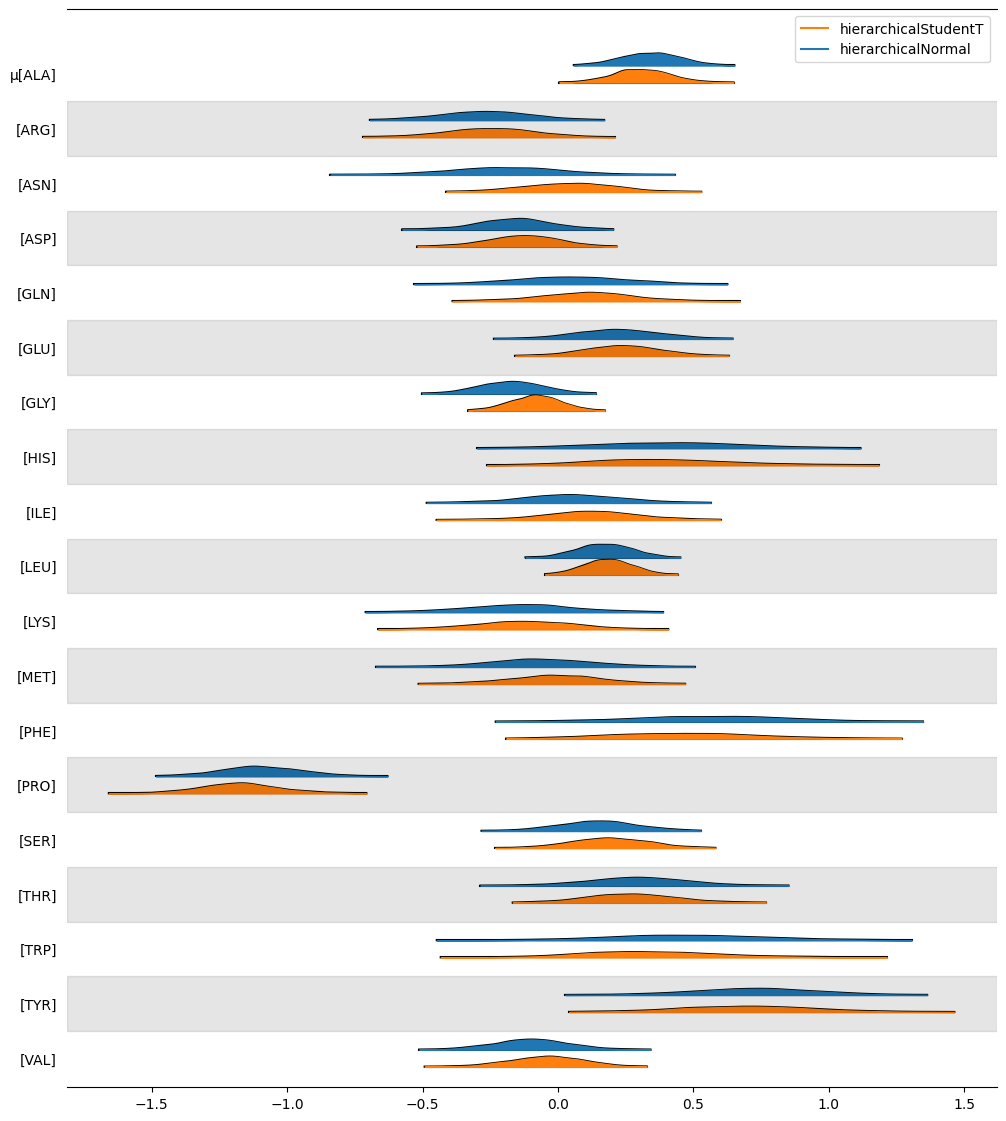

In [ ]:
axes = az.plot_forest([idata_cs_h, idata_cs_hstu], kind="ridgeplot",
                      model_names=['hierarchicalNormal', 'hierarchicalStudentT'],
                      var_names='μ', combined=True, figsize=(12, 14),hdi_prob=0.997)

**Task2**:

Run a posterior predictive check for both models. Which seems to fit the data better?

Output()

<Axes: xlabel='y'>

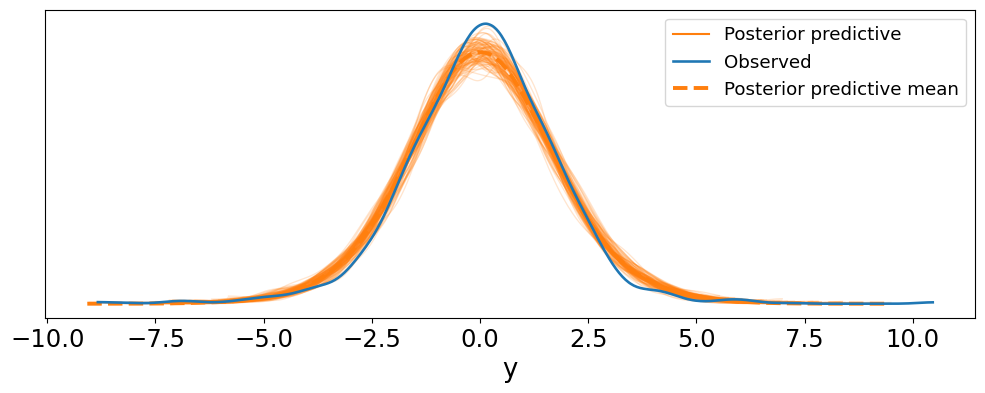

In [ ]:
pm.sample_posterior_predictive(idata_cs_h, model=cs_h_model, extend_inferencedata=True)
az.plot_ppc(idata_cs_h, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

Output()

(-10.0, 10.0)

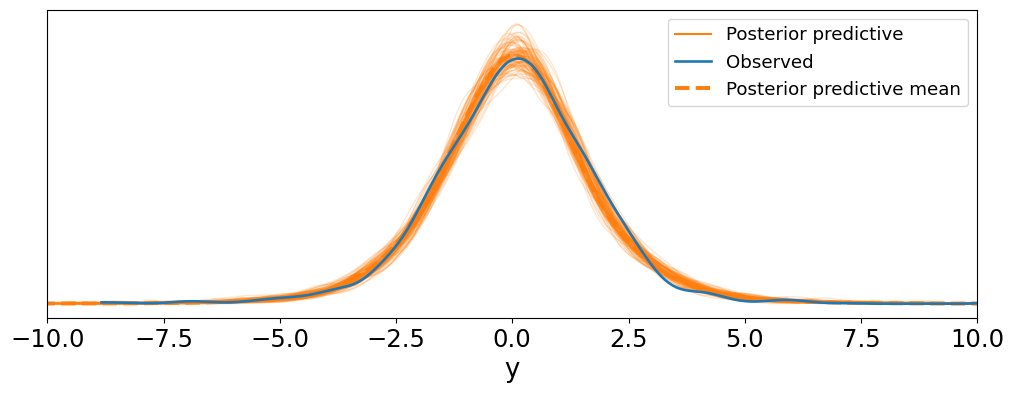

In [ ]:
pm.sample_posterior_predictive(idata_cs_hstu, model=cs_hstu_model, extend_inferencedata=True)
ax=az.plot_ppc(idata_cs_hstu, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])
ax.set_xlim(-10, 10)

**Task3**:

Redo the soccer model, but this time, assume the groups are independent. This will be a non-hierarchical model.

In [ ]:

url_sccr = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/football_players.csv'


sccr_data = pd.read_csv(url_sccr,dtype={'position':'category'})

pos_idx = sccr_data.position.cat.codes.values


pos_codes = sccr_data.position.cat.categories


sccr_coords = {"pos": pos_codes}

In [ ]:
with pm.Model(coords = sccr_coords) as sccr_model:


    μ_p = pm.Beta('μ_p', alpha = 2, beta = 20, dims = "pos")

    ν_p = pm.Gamma('ν_p', mu = 55, sigma = 45, dims="pos")


    θ = pm.Beta('θ', mu = μ_p[pos_idx], nu = ν_p[pos_idx])


    _ = pm.Binomial('gs',
                    n = sccr_data.shots.values,
                    p = θ,
                    observed = sccr_data.goals.values)


    idata_sccr = pm.sample(target_accept = 0.98)

Output()

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


**Task4**:

Run plot trace and rhat on your inference data object for the non-hierarchical soccer model. How does this compare to the hierarchical model?

<xarray.Dataset> Size: 43kB
Dimensions:  (θ_dim_0: 2682, pos: 4)
Coordinates:
  * θ_dim_0  (θ_dim_0) int64 21kB 0 1 2 3 4 5 ... 2676 2677 2678 2679 2680 2681
  * pos      (pos) <U2 32B 'DF' 'FW' 'GK' 'MF'
Data variables:
    θ        (θ_dim_0) float64 21kB 0.9996 0.9998 1.0 ... 1.002 0.9995 0.9998
    μ_p      (pos) float64 32B 1.0 1.0 1.317 1.01
    ν_p      (pos) float64 32B 1.04 1.003 1.185 1.016

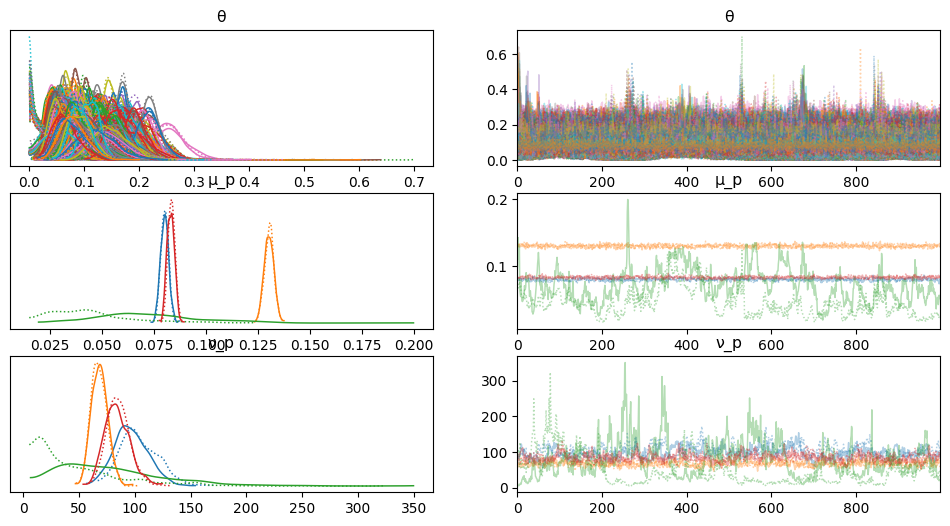

In [ ]:
az.plot_trace(idata_sccr)
az.rhat(idata_sccr)

Compared to the hierarchical model shown in the notes’ answer key, the Rhat values for the non-hierarchical model are closer to ideal, falling between 1 and 1.001, with only a few slightly outside this range but still under 1.09—even for the goalkeeper position, which does not exceed 1.1. This is a clear improvement over the hierarchical model’s Rhat value of 1.242. Regarding the trace plots, they appear similar between the models. In the μ_p graph, the red peaks higher in the non-hierarchical model, though the solid and dotted lines stay close together across all peaks. For the ν_p plot, the non-hierarchical model looks a bit cleaner overall, except for the green trace.


**Task5**:

Plot the posterior of the means for each soccer position in the non-hierarchical model.

How do these posteriors compare to the hierarchical model we did in class?

array([<Axes: >], dtype=object)

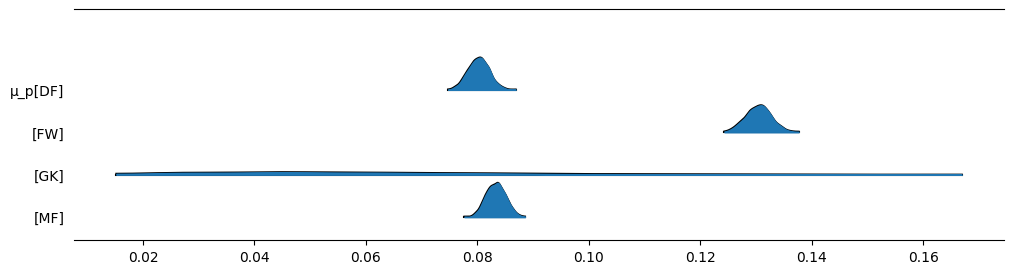

In [ ]:
az.plot_forest(idata_sccr, var_names=['μ_p'], combined=True, figsize=(12, 3), kind = 'ridgeplot', hdi_prob=0.998)

These posteriors are narrower and smoother than the hierarchical model from in class. This means they are little more certain than the previous one.

**Task6**:

Redo the soccer model as a hierarchical model, but remove all the goalkeepers (GK) from the data. In other words, run a hierarchical model on only the defenders, midfielders, and forwards.

In [ ]:
sccr_data_noG = sccr_data[sccr_data.position != 'GK'].copy()
sccr_data_noG['position'] = pd.Categorical(sccr_data_noG['position'])
sccr_data_noG['position'] = sccr_data_noG['position'].cat.remove_unused_categories()

In [ ]:
pos_idx_noG = sccr_data_noG.position.cat.codes.values

pos_codes_noG = sccr_data_noG.position.cat.categories

sccr_coords_noG = {"pos": pos_codes_noG}

print(pos_codes_noG)
print(sccr_coords_noG)

Index(['DF', 'FW', 'MF'], dtype='object')
{'pos': Index(['DF', 'FW', 'MF'], dtype='object')}


In [ ]:
with pm.Model(coords = sccr_coords_noG) as sccr_model_noG:

    μ = pm.Beta('μ', alpha = 2, beta = 20)
    ν = pm.Gamma('ν', mu = 55, sigma = 45)



    μ_p = pm.Beta('μ_p', mu = μ, nu = ν, dims = "pos")

    ν_p = pm.Gamma('ν_p', mu = 55, sigma = 45, dims="pos")


    θ = pm.Beta('θ', mu = μ_p[pos_idx_noG], nu = ν_p[pos_idx_noG])


    _ = pm.Binomial('gs',
                    n = sccr_data_noG.shots.values,
                    p = θ,
                    observed = sccr_data_noG.goals.values)
    idata_sccr_noG = pm.sample(target_accept = 0.95)



Sampling chain 1, 0 divergences ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 / 0:02:20

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


**Task7**:

Compare the plot trace and rhat results for the hierarchical model with GKs and without GKs. Then answer the following questions:
- Which model was easier for pymc to process?
- What do we lose by dropping Gks from the data set? What do we gain?

array([<Axes: >], dtype=object)

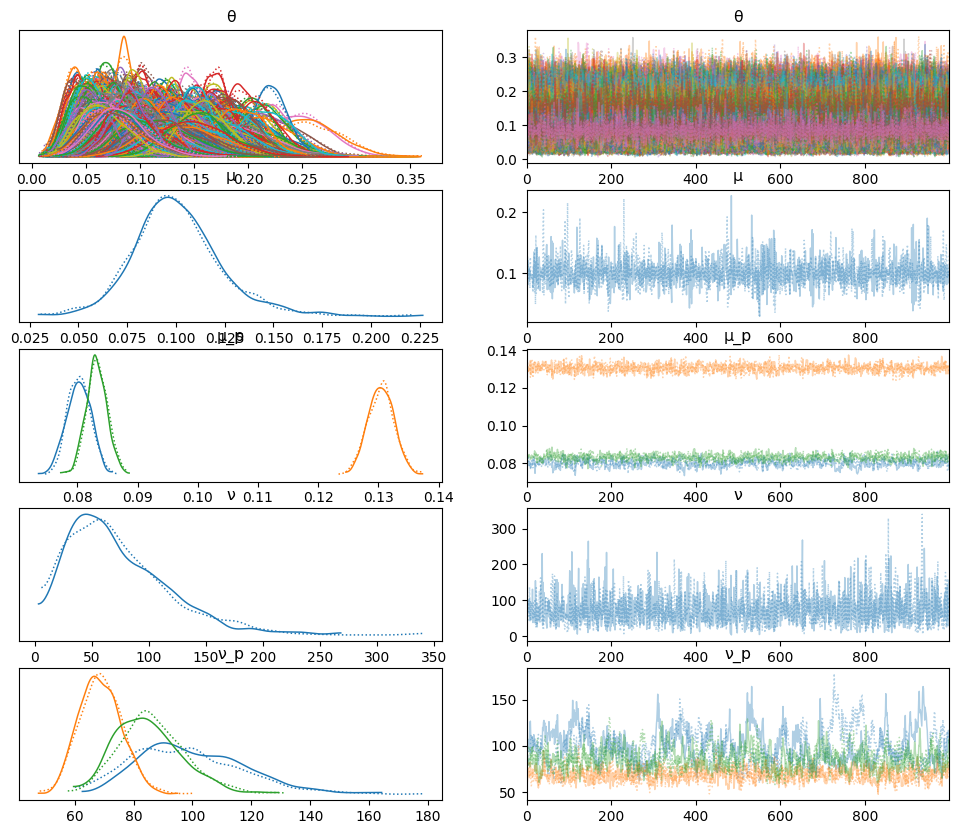

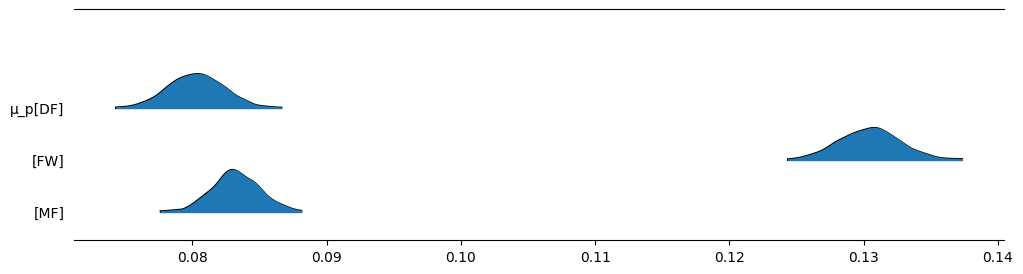

In [ ]:
az.plot_trace(idata_sccr_noG)
az.rhat(idata_sccr_noG)
az.plot_forest(idata_sccr_noG, var_names=['μ_p'], combined=True, figsize=(12, 3), kind = 'ridgeplot', hdi_prob=0.998)